# Deep Learning: Endoscopy segmentation.
[Dataset](https://www.kaggle.com/datasets/newslab/cholecseg8k?resource=download)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import cv2
import tensorflow as tf
import keras.backend as K
from sklearn.model_selection import train_test_split
from glob import glob
import segmentation_models as sm
from keras_vision_transformer import swin_layers
from keras_vision_transformer import transformer_layers
from keras_vision_transformer import utils

Segmentation Models: using `keras` framework.


In [2]:
tf.keras.backend.clear_session()
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
print('GPU avalible: ' + str(len(tf.config.get_visible_devices('GPU')) > 0))

GPU avalible: True


In [3]:
SEED = 33
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Data preparation.

In [4]:
imgs = glob(f'../*/*/*/frame_*_endo.png')
masks = glob(f'../*/*/*/frame_*_endo_watershed_mask.png')

assert len(imgs) == len(masks)

print(f'Number of samples: {str(len(masks))}')

Number of samples: 8080


In [5]:
HEIGHT, WIDTH = 64, 64
N = len(masks)
CLASS_WEIGHTS = np.array([2.45780159e-01, 2.24610010e-01, 2.24005501e-01, 1.87119512e-02,
 1.46965911e-01, 2.54698498e-02, 2.35562466e-02, 4.28713053e-03,
 3.93593665e-04, 1.38500705e-02, 6.78984614e-02, 1.01436955e-04,
 4.36967906e-03])


In [6]:
X, y = [], []

for img, mask in zip(imgs, masks):
    img = cv2.imread(img)
    img = img[10:-10, 10:-10,:]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (WIDTH, HEIGHT))
    img = img / 255
    X.append(img)

    mask = cv2.imread(mask)
    mask = mask[10:-10, 10:-10,:]
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = cv2.resize(mask, (WIDTH, HEIGHT), interpolation=cv2.INTER_NEAREST)
    mask = np.expand_dims(mask, axis=-1)

    y.append(mask)

X = np.array(X)
y = np.array(y)

assert X.shape[0:-1] == y.shape[0:-1]

X.shape, y.shape

((8080, 64, 64, 3), (8080, 64, 64, 1))

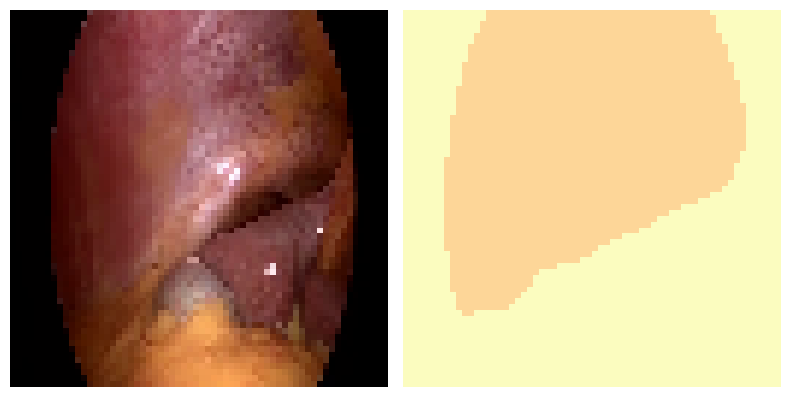

In [7]:
idx = random.randint(0, len(X)-1)

plt.figure(figsize=(8,8))
plt.subplot(121)
plt.imshow(X[idx])
plt.axis("off")
plt.subplot(122)
plt.imshow(y[idx], cmap='magma', norm=plt.Normalize(vmin=0, vmax=12))
plt.axis("off")
plt.tight_layout()
plt.show()

In [8]:
labels = [[11],[21],[13],[12],[31],[23],[24],[25],[32],[22],[33],[5]]

y_encoded = np.zeros((N, HEIGHT, WIDTH, 1), dtype=np.uint8)

for i, label in enumerate(labels):
    y_encoded[np.all(label == y, axis=-1)] = i + 1
 
y = tf.keras.utils.to_categorical(y_encoded, num_classes=13)

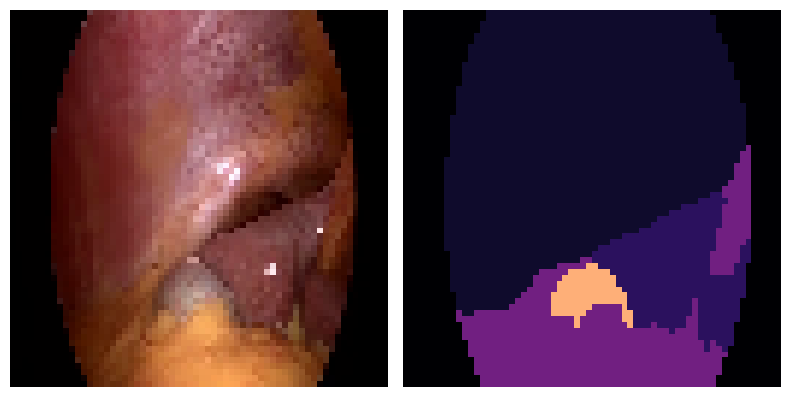

In [9]:
plt.figure(figsize=(8,8))
plt.subplot(121)
plt.imshow(X[idx])
plt.axis("off")
plt.subplot(122)
plt.imshow(tf.argmax(y[idx], axis=-1), cmap='magma', norm=plt.Normalize(vmin=0, vmax=12))
plt.axis("off")
plt.tight_layout()
plt.show()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43) 
import gc
del X
del y
gc.collect()

8152

## Swin-U-Net

### Losses

In [11]:
def dice_coeficient(y_true, y_pred):
    T = tf.keras.backend.flatten(y_true)
    P = tf.keras.backend.flatten(y_pred)

    intersection = tf.keras.backend.sum(T * P)
    dice = (2 * intersection) / (tf.keras.backend.sum(T + P))
    return dice

def dice_loss(y_true, y_pred):
    return 1 - dice_coeficient(y_true, y_pred)

def tversky(y_true, y_pred, smooth=1e-6, alpha=0.75):
    T = tf.keras.backend.flatten(y_true)
    P = tf.keras.backend.flatten(y_pred)
    TP = tf.keras.backend.sum(T * P)
    FN = tf.keras.backend.sum(T * (1 - P))
    FP = tf.keras.backend.sum((1 - T) * P)
    return (TP + smooth) / (TP + alpha * FN + (1 - alpha) * FP + smooth)


def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true, y_pred)


# def focal_tversky_loss(y_true, y_pred, gamma=0.75):
#     tv = tversky(y_true, y_pred)
#     return tf.keras.backend.pow((1 - tv), gamma)

### Swin transformer stack

In [12]:
def swin_transformer_stack(X, stack_num, embed_dim, num_patch, num_heads, window_size, num_mlp, shift_window=True, name=''):
    '''
    Stacked Swin Transformers that share the same token size.
    
    Alternated Window-MSA and Swin-MSA will be configured if `shift_window=True`, Window-MSA only otherwise.
    *Dropout is turned off.
    '''
    # Turn-off dropouts
    mlp_drop_rate = 0 # Droupout after each MLP layer
    attn_drop_rate = 0 # Dropout after Swin-Attention
    proj_drop_rate = 0 # Dropout at the end of each Swin-Attention block, i.e., after linear projections
    drop_path_rate = 0 # Drop-path within skip-connections
    
    qkv_bias = True # Convert embedded patches to query, key, and values with a learnable additive value
    qk_scale = None # None: Re-scale query based on embed dimensions per attention head # Float for user specified scaling factor
    
    if shift_window:
        shift_size = window_size // 2
    else:
        shift_size = 0
    
    for i in range(stack_num):
    
        if i % 2 == 0:
            shift_size_temp = 0
        else:
            shift_size_temp = shift_size

        X = swin_layers.SwinTransformerBlock(dim=embed_dim, 
                                             num_patch=num_patch, 
                                             num_heads=num_heads, 
                                             window_size=window_size, 
                                             shift_size=shift_size_temp, 
                                             num_mlp=num_mlp, 
                                             qkv_bias=qkv_bias, 
                                             qk_scale=qk_scale,
                                             mlp_drop=mlp_drop_rate, 
                                             attn_drop=attn_drop_rate, 
                                             proj_drop=proj_drop_rate, 
                                             drop_path_prob=drop_path_rate, 
                                             name='name{}'.format(i))(X)
    return X


def swin_unet_2d_base(input_tensor, filter_num_begin, depth, stack_num_down, stack_num_up, 
                      patch_size, num_heads, window_size, num_mlp, shift_window=True, name='swin_unet'):
    '''
    The base of Swin-UNET.
    
    The general structure:
    
    1. Input image --> a sequence of patches --> tokenize these patches
    2. Downsampling: swin-transformer --> patch merging (pooling)
    3. Upsampling: concatenate --> swin-transfprmer --> patch expanding (unpooling)
    4. Model head
    
    '''
    # Compute number be patches to be embeded
    input_size = input_tensor.shape.as_list()[1:]
    num_patch_x = input_size[0]//patch_size[0]
    num_patch_y = input_size[1]//patch_size[1]
    
    # Number of Embedded dimensions
    embed_dim = filter_num_begin
    
    depth_ = depth
    
    X_skip = []

    X = input_tensor
    
    # Patch extraction
    X = transformer_layers.patch_extract(patch_size)(X)

    # Embed patches to tokens
    X = transformer_layers.patch_embedding(num_patch_x*num_patch_y, embed_dim)(X)
    
    # The first Swin Transformer stack
    X = swin_transformer_stack(X, 
                               stack_num=stack_num_down, 
                               embed_dim=embed_dim, 
                               num_patch=(num_patch_x, num_patch_y), 
                               num_heads=num_heads[0], 
                               window_size=window_size[0], 
                               num_mlp=num_mlp, 
                               shift_window=shift_window, 
                               name='{}_swin_down0'.format(name))
    X_skip.append(X)
    
    # Downsampling blocks
    for i in range(depth_-1):
        
        # Patch merging
        X = transformer_layers.patch_merging((num_patch_x, num_patch_y), embed_dim=embed_dim, name='down{}'.format(i))(X)
        
        # update token shape info
        embed_dim = embed_dim*2
        num_patch_x = num_patch_x//2
        num_patch_y = num_patch_y//2
        
        # Swin Transformer stacks
        X = swin_transformer_stack(X, 
                                   stack_num=stack_num_down, 
                                   embed_dim=embed_dim, 
                                   num_patch=(num_patch_x, num_patch_y), 
                                   num_heads=num_heads[i+1], 
                                   window_size=window_size[i+1], 
                                   num_mlp=num_mlp, 
                                   shift_window=shift_window, 
                                   name='{}_swin_down{}'.format(name, i+1))
        
        # Store tensors for concat
        X_skip.append(X)
        
    # reverse indexing encoded tensors and hyperparams
    X_skip = X_skip[::-1]
    num_heads = num_heads[::-1]
    window_size = window_size[::-1]
    
    # upsampling begins at the deepest available tensor
    X = X_skip[0]
    
    # other tensors are preserved for concatenation
    X_decode = X_skip[1:]
    
    depth_decode = len(X_decode)
    
    for i in range(depth_decode):
        
        # Patch expanding
        X = transformer_layers.patch_expanding(num_patch=(num_patch_x, num_patch_y), 
                                               embed_dim=embed_dim, 
                                               upsample_rate=2, 
                                               return_vector=True)(X)
        

        # update token shape info
        embed_dim = embed_dim//2
        num_patch_x = num_patch_x*2
        num_patch_y = num_patch_y*2
        
        # Concatenation and linear projection
        X = tf.keras.layers.concatenate([X, X_decode[i]], axis=-1, name='{}_concat_{}'.format(name, i))
        X = tf.keras.layers.Dense(embed_dim, use_bias=False, name='{}_concat_linear_proj_{}'.format(name, i))(X)
        
        # Swin Transformer stacks
        X = swin_transformer_stack(X, 
                                   stack_num=stack_num_up, 
                                   embed_dim=embed_dim, 
                                   num_patch=(num_patch_x, num_patch_y), 
                                   num_heads=num_heads[i], 
                                   window_size=window_size[i], 
                                   num_mlp=num_mlp, 
                                   shift_window=shift_window, 
                                   name='{}_swin_up{}'.format(name, i))
        
    # The last expanding layer; it produces full-size feature maps based on the patch size
    # !!! <--- "patch_size[0]" is used; it assumes patch_size = (size, size)
    
    X = transformer_layers.patch_expanding(num_patch=(num_patch_x, num_patch_y), 
                                           embed_dim=embed_dim, 
                                           upsample_rate=patch_size[0], 
                                           return_vector=False)(X)
    
    return X

### Hyperparameters

In [13]:
filter_num_begin = 128     # number of channels in the first downsampling block; it is also the number of embedded dimensions
depth = 4                  # the depth of SwinUNET; depth=4 means three down/upsampling levels and a bottom level 
stack_num_down = 2         # number of Swin Transformers per downsampling level
stack_num_up = 2           # number of Swin Transformers per upsampling level
patch_size = (4, 4)        # Extract 4-by-4 patches from the input image. Height and width of the patch must be equal.
num_heads = [4, 8, 8, 8]   # number of attention heads per down/upsampling level
window_size = [4, 2, 2, 2] # the size of attention window per down/upsampling level
num_mlp = 512              # number of MLP nodes within the Transformer
shift_window=True          # Apply window shifting, i.e., Swin-MSA

### Model configuration

In [14]:
# Input section
IN = tf.keras.layers.Input((WIDTH, HEIGHT, 3))

# Base architecture
X = swin_unet_2d_base(IN, filter_num_begin, depth, stack_num_down, stack_num_up, 
                      patch_size, num_heads, window_size, num_mlp, 
                      shift_window=shift_window, name='swin_unet')



# Output section
n_labels = 13
OUT = tf.keras.layers.Conv2D(n_labels, kernel_size=1, use_bias=False, activation='softmax')(X)

# Model configuration
swin_transformer = tf.keras.models.Model(inputs=[IN,], outputs=[OUT,])
# Optimization
# <---- !!! gradient clipping is important
swin_transformer.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, clipvalue=0.5, decay=1e-6), 
    loss=sm.losses.DiceLoss(class_weights=CLASS_WEIGHTS),
    metrics=[tf.metrics.MeanIoU(num_classes=13), dice_coeficient]
)
swin_transformer.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 patch_extract (patch_extract)  (None, 256, 48)      0           ['input_1[0][0]']                
                                                                                                  
 patch_embedding (patch_embeddi  (None, 256, 128)    39040       ['patch_extract[0][0]']          
 ng)                                                                                              
                                                                                                  
 swin_transformer_block (SwinTr  (None, 256, 128)    198724      ['patch_embedding[0][0]']    

In [15]:
# print('\n\t EVALUATION\n')
# swin_transformer.evaluate(
#     X_test, 
#     y_test,
#     batch_size=32
# )

# checkpoint = tf.keras.callbacks.ModelCheckpoint(
#     '../models/swin-unet_train_Weights.hdf5',
#     verbose=1,
#     save_best_only=True,
#     save_weights_only=True,
#     mode='auto'
# )

# tf.keras.backend.clear_session()
print('\n\t TRAINING\n')

model_history = swin_transformer.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=128,
    validation_data=(X_test, y_test),
    use_multiprocessing=True,
    # callbacks=[checkpoint],
    verbose=1
)

swin_transformer.save_weights('../models/swin-unet_DiceLoss_Class_Weights.hdf5')


	 TRAINING

Epoch 1/100
51/51 [==============================] - 35s 359ms/step - loss: 0.9860 - mean_io_u: 0.4615 - dice_coeficient: 0.1543 - val_loss: 0.9808 - val_mean_io_u: 0.4615 - val_dice_coeficient: 0.2179
Epoch 2/100
51/51 [==============================] - 15s 297ms/step - loss: 0.9765 - mean_io_u: 0.4615 - dice_coeficient: 0.2706 - val_loss: 0.9726 - val_mean_io_u: 0.4615 - val_dice_coeficient: 0.3218
Epoch 3/100
51/51 [==============================] - 15s 303ms/step - loss: 0.9690 - mean_io_u: 0.4615 - dice_coeficient: 0.3687 - val_loss: 0.9655 - val_mean_io_u: 0.4615 - val_dice_coeficient: 0.4159
Epoch 4/100
51/51 [==============================] - 16s 311ms/step - loss: 0.9621 - mean_io_u: 0.4616 - dice_coeficient: 0.4617 - val_loss: 0.9590 - val_mean_io_u: 0.4615 - val_dice_coeficient: 0.5040
Epoch 5/100
51/51 [==============================] - 16s 320ms/step - loss: 0.9564 - mean_io_u: 0.4616 - dice_coeficient: 0.5387 - val_loss: 0.9544 - val_mean_io_u: 0.4616 - val_d

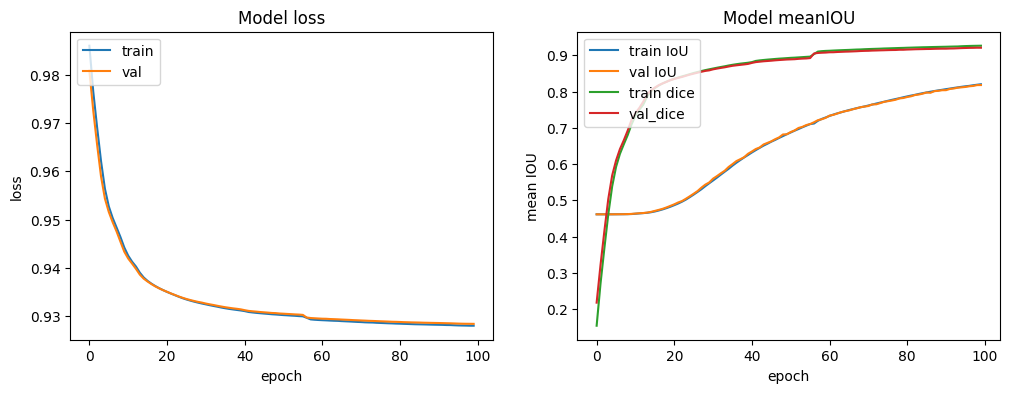

In [16]:
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(122)
plt.plot(model_history.history['mean_io_u'])
plt.plot(model_history.history['val_mean_io_u'])
plt.plot(model_history.history['dice_coeficient'])
plt.plot(model_history.history['val_dice_coeficient'])
plt.title('Model meanIOU')
plt.ylabel('mean IOU')
plt.xlabel('epoch')
# plt.yticks(np.arange(0, 1.1, 0.1))

plt.legend(['train IoU', 'val IoU', 'train dice', 'val_dice'], loc='upper left')

plt.show()

In [17]:
# unet_model = build_unet_model(n_filters=32, n_classes=13)
# unet_model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=0e-4), 
#     loss=dice_loss,
#     metrics=[tf.metrics.MeanIoU(num_classes=13), dice_coeficient]
# )

# unet_model.load_weights('../models/swin-unet_Weights.hdf5')

In [18]:
pred = swin_transformer.predict(X_test)
pred = np.array(pred)
pred = tf.argmax(pred, axis=-1)

51/51 [==============================] - 5s 54ms/step


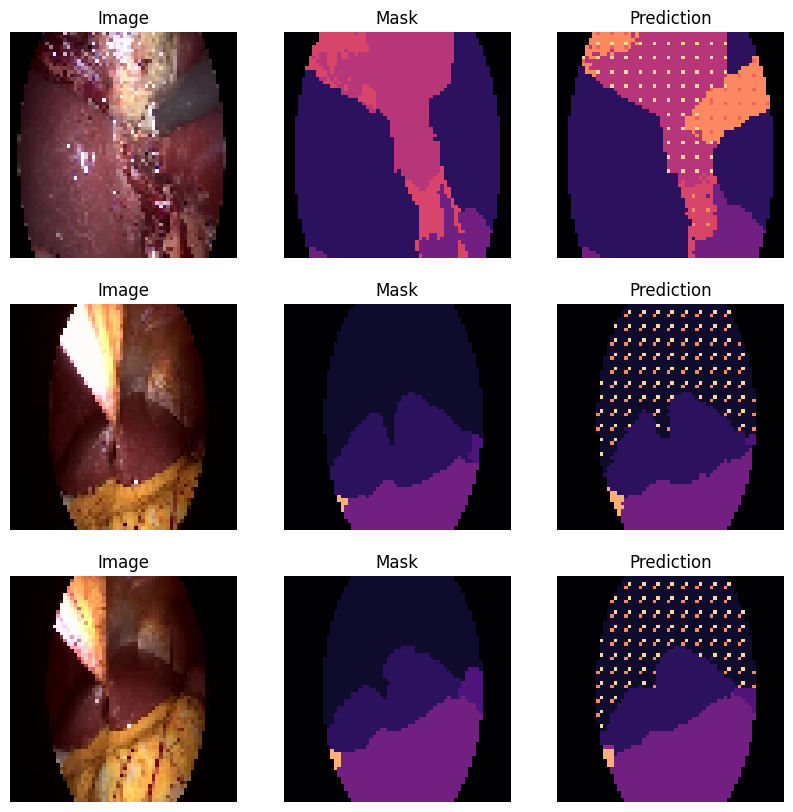

In [19]:
plt.figure(figsize=(10,10))
for i in range(3):    
    idx = random.randint(0, len(pred)-1)

    plt.subplot(331 + 3*i)
    plt.imshow(X_test[idx])
    plt.title('Image')
    plt.axis("off")

    plt.subplot(332 + 3*i)
    plt.imshow(tf.argmax(y_test[idx], axis=-1), cmap='magma', norm=plt.Normalize(vmin=0, vmax=12))
    plt.title('Mask')
    plt.axis("off")

    plt.subplot(333 + 3*i)
    plt.imshow(pred[idx], cmap='magma', norm=plt.Normalize(vmin=0, vmax=12))
    plt.title('Prediction')
    plt.axis("off")

plt.show()

 --- 
 TFG - Alejandro García Mota